# Analysis of SEIRX model runs for test technology and vaccination ratios

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import analysis_functions as af

In [2]:
N_runs = 5000
sim_name = 'simulations_testing_and_vaccination_{}.csv'.format(N_runs)
res_path = '../data/simulation_results'
dst_path = '../plots'

### Mappings of variables to nicer labels for plots

In [3]:
frequency_name_map = {np.nan:'never',
              2:'3 times\na week',
              3:'twice\na week',
              7:'once\na week'}

test_name_map = {'same_day_antigen':'same-day antigen', 'one_day_PCR':'one day PCR',
             'two_day_PCR':'two days PCR', 'same_day_PCR':'same-day PCR',
             'same_day_LAMP':'same-day RT-LAMP'}

metric_name_map = {'infected_residents_mean':'follow-up cases residents (mean)',
                   'infected_residents_median':'follow-up cases residends (median)',
                   'infected_residents_0.90':'follow-up cases residents (90th percentile)',
                   'R0_mean':'$R_0$',
                   'R0_mean':'$R_0$'}

index_case_map = {'employee':'index case employee',
                  'resident':'index case resident'}

screening_intervals = ['never', 'once\na week', 'twice\na week', '3 times\na week']

## Load the simulation results

In [4]:
data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

data = data.set_index(['test_type', 'index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

In [6]:
data['test_rate_mean']

test_type         index_case  employee_vaccination_ratio  resident_vaccination_ratio  employee_screen_interval  resident_screen_interval
same_day_antigen  employee    0.5                         0.9                         3 times\na week           3 times\na week             0.424450
                              0.9                         0.9                         3 times\na week           once\na week                0.234255
                                                                                                                twice\na week               0.329383
                                                                                                                3 times\na week             0.423831
                              0.5                         0.9                         3 times\na week           once\na week                0.233045
                                                                                                                      

## Different vaccination scenarios

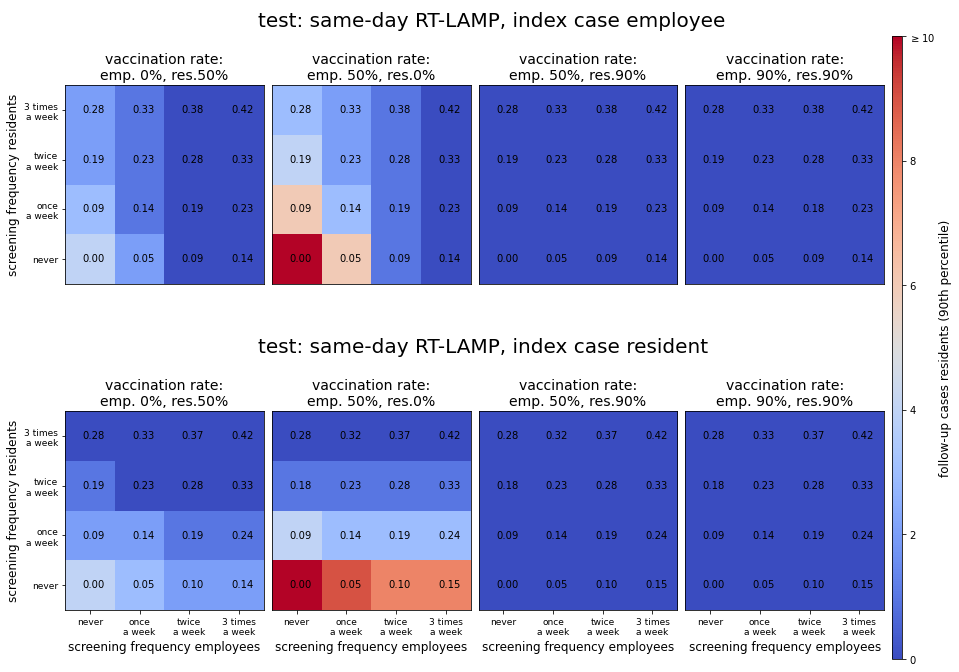

In [7]:
metric = 'infected_residents_0.90'
#sim_name = 'simulation_results'
test_type = 'same_day_LAMP'
screening_params = screening_intervals
vacc_scenarios = [(0.0, 0.5), (0.5, 0.0), (0.5, 0.9), (0.9, 0.9)]
xlabel = 'screening frequency employees'
ylabel = 'screening frequency residents'

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=5, width_ratios=[1,1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])
hmap_ax_4 = fig.add_subplot(gs[1, 3])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_5 = fig.add_subplot(gs[3, 0])
hmap_ax_6 = fig.add_subplot(gs[3, 1])
hmap_ax_7 = fig.add_subplot(gs[3, 2])
hmap_ax_8 = fig.add_subplot(gs[3, 3])

cbar_ax = fig.add_subplot(gs[1:, 4])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3, hmap_ax_4],
             [hmap_ax_5, hmap_ax_6, hmap_ax_7, hmap_ax_8]]

title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin=0
vmax=10
vstep=2

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data.loc[test_type, index_case_mode, :, :]
    
    # remove all axis labels and ticks for the heatmaps
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.23, 1, 'test: {}, '.format(test_name_map[test_type]) +\
              index_case_map[index_case_mode], fontsize=20)
        
    j = 0
    # compare same-day turnover testing for different testing technologies
    for j, ax, vacc_scenario in zip(range(4), hmap_axes[i], vacc_scenarios):
        
        # set flag to set axis ticks only for heatmaps at the boundaries of 
        # the figure
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 4]:
            yticks = True
            
        # put the testing technology in the heatmap title
        ax.set_title('vaccination rate:\nemp. {:1.0f}%, res.{:1.0f}%'\
                .format(vacc_scenario[0] * 100, vacc_scenario[1] * 100),
                     fontsize=14)
        
        # plot heatmap of the scenario
        img = af.get_image(df.loc[vacc_scenario[0]], vacc_scenario[1],
                        screening_params, metric)
        if index_case_mode == 'resident':
            # if a resident is the index case, we need to subtract 1 from the
            # number of infected residents, to calculate the "outbreak size",
            # which is defined as the number of FOLLOW-UP cases, given an index
            # case
            img = img - 1
        img_plot = af.plot_heatmap(ax, img, screening_params, vmin, vmax, xticks,
                                yticks, xlabel, ylabel)
        
        # annotate heatmap with tests / days / agent
        test_rate = af.get_image(df.loc[vacc_scenario[0]],
                vacc_scenario[1], screening_params, 'test_rate_mean')

        af.annotate_heatmap(ax, test_rate)
        
# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                        ticks=np.arange(vmin, vmax + 1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path, 'testing_strategy_and_vaccinations_{}.png'\
                 .format(test_type)), dpi=300, transparent=True)
plt.savefig(join(dst_path, 'testing_strategy_and_vaccinations_{}.pdf'\
                 .format(test_type)), transparent=True)